# ESG Score Prediction

## Notebook Outline :

1. Introduction (ESG Score, Calculation method, Factors - Summary based on the TR pdf)
2. Data Explanation (Features - what they are)
3. Data Processing - Outlier Detection, Feature Transformation 
4. EDA - Basic Insights
6. Feature Selection/Importance
5. Data Modelling

## 1. Introduction 

A financial statement lists the assets, liabilities and equity of a company at a specific point in time and is used to calculate the net worth of a business. A basic tenet of double-entry book-keeping is that total assets (what a business owns) must equal liabilities plus equity (how the assets are financed). In other words, the balance sheet must balance. Subtracting liabilities from assets shows the net worth of the business. 

How does ESG score come into picture in a business?
(TBD by Aheli)


## 2. Data Explanation  

### Total Current Assets 
Current assets are cash or its equivalent or those assets that will be used by the business in a year or less

### Total Current Liabilities 
Debts that are due in one year or less are classified as current liabilities. If they're due in more than one year, they're long-term liabilities.

### Total Debt 
Total debt refers to the sum of borrowed money that your business owes. It’s calculated by adding together your current and long-term liabilities.

### Total Assets Reported 
"Total long-term assets" is the sum of capital and plant, investments, and miscellaneous assets.
"Total assets" is the sum of total current assets and total long-term assets

### Net Income - Actual 
Net income refers to the amount an individual or business makes after deducting costs, allowances and taxes.
In commerce, net income is what the business has left over after all expenses, including salary and wages, cost of goods or raw material and taxes. 

### Revenue Per Share
1. Earnings per share (EPS) is a company's net profit divided by the number of common shares it has outstanding.
2. EPS indicates how much money a company makes for each share of its stock and is a widely used metric for estimating corporate value.
3. A higher EPS indicates greater value because investors will pay more for a company's shares if they think the company has higher profits relative to its share price.
4. EPS can be arrived at in several forms, such as excluding extraordinary items or discontinued operations, or on a diluted basis.
5. Like other financial metrics, earnings per share is most valuable when compared against competitor metrics, companies of the same industry, or across a period of time.

### Total Revenue 
Total revenue is the amount of money a company brings in from selling its goods and services. In other words, company's use this metric to determine how well they're generating money from their core revenue-driving operations.

### Total Equity 
The total equity of a business is derived by subtracting its liabilities from its assets. The information for this calculation can be found on a company's balance sheet, which is one of its financial statements. 
An alternative approach for calculating total equity is to add up all of the line items in the stockholders' equity section of the balance sheet, which is comprised of common stock, additional paid-in capital, and retained earnings, minus treasury stock.
In essence, total equity is the amount invested in a company by investors in exchange for stock, plus all subsequent earnings of the business, minus all subsequent dividends paid out. Many smaller businesses are strapped for cash and so have never paid any dividends. In their case, total equity is simply invested funds plus all subsequent earnings.

### Company Market Capitilization 
Market cap—or market capitalization—refers to the total value of all a company's shares of stock. It is calculated by multiplying the price of a stock by its total number of outstanding shares. For example, a company with 20 million shares selling at $50 a share would have a market cap of $1 billion.

Why is market capitalization such an important concept? It allows investors to understand the relative size of one company versus another. Market cap measures what a company is worth on the open market, as well as the market's perception of its future prospects, because it reflects what investors are willing to pay for its stock.

### Property Plant And Equipment, Total - Gross
Carrying amount at the balance sheet date for long-lived physical assets used in the normal conduct of business and not intended for resale. This can include land, physical structures, machinery, vehicles, furniture, computer equipment, construction in progress, and similar items.

### P/E Ratio
The price/earnings (P/E) ratio, also known as an “earnings multiple,” is one of the most popular valuation measures used by investors and analysts. The basic definition of a P/E ratio is stock price divided by earnings per share (EPS)


## 3. Data Exploration

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import numpy as np
import plotly.express as px

### Firm Data Import

In [ ]:
firm_data = pd.read_csv("Firm Data.csv")

In [ ]:
firm_data.head()

In [ ]:
firm_data.shape

In [ ]:
firm_data.columns

In [ ]:
firm_data.info()

Share of NaN values in the data

In [ ]:
firm_data.isnull().sum() / len(firm_data) * 100

Converting object to datatime

In [ ]:
firm_data["Date"] = pd.to_datetime(firm_data["Date"], format="%d/%m/%Y")
firm_data["Date"].value_counts()

### Return Data Import

In [ ]:
return_data = pd.read_csv("Return_Data.csv")
return_data = return_data.drop("Unnamed: 0", axis=1)

In [ ]:
return_data.head()

In [ ]:
return_data[["Date", "HL"]].info()

In [ ]:
return_data["Date"] = pd.to_datetime(return_data["Date"], format="%Y/%m/%d")
return_data["Date"].nunique()

We have data from 2000s in the return data. However, in our firm data - we have data only from 2009. 
Hence, we will limit our return data as per the timeline of firm data

In [ ]:
firm_data["Date"].min(), firm_data["Date"].max()

In [ ]:
return_data["Date"].min(), return_data["Date"].max()

In [ ]:
start_date = "2009-01-01"
end_date = "2021-12-31"
mask = return_data["Date"].between(start_date, end_date)
return_data = return_data[mask]

In [ ]:
return_data["Date"] = pd.to_datetime(return_data["Date"], format="%Y/%m/%d")
return_data["Date"].nunique()

In [ ]:
return_data["Date"].min(), return_data["Date"].max()

Transforming columns to rows

In [ ]:
return_data = pd.melt(
    return_data, id_vars="Date", var_name="RIC", value_name="returns_monthly"
)

### Combining Return Data with Firm Data

Before we combine, we need to bring return data to year level since firm data is at the year level. 

In [ ]:
return_data["Year"] = return_data["Date"].dt.year

In [ ]:
return_data.head()

In [ ]:
returns_yearly = return_data.groupby(
    [return_data["RIC"], return_data["Year"]], as_index=False
)["returns_monthly"].sum()
returns_yearly.rename(
    columns={"returns_monthly": "returns_yearly"}, inplace=True
)
returns_yearly.head()

In [ ]:
returns_yearly.Year.min(), returns_yearly.Year.max()

In [ ]:
returns_yearly.to_csv("data/yearly_return.csv", index=False)

In [ ]:
firm_data["Year"] = firm_data["Date"].dt.year

In [ ]:
firm_data = firm_data.merge(returns_yearly, how="left", on=["RIC", "Year"])

In [ ]:
firm_data.head()

In [ ]:
firm_data.drop(
    columns=[
        "Date",
        "Social Pillar Score",
        "Governance Pillar Score",
        "Environmental Pillar Score",
    ],
    inplace=True,
)

In [ ]:
firm_data.to_csv("data/firm_returns_merged.csv", index=False)

In [ ]:
firm_data.head()

### Correlation heatmaps

It is clear from the heatmap that there is a strong correlation among the following features

In [ ]:
columns = [
    "Total Current Assets",
    "Total Current Liabilities",
    "Total Debt",
    "Total Assets, Reported",
    "Net Income - Actual",
    "Total Revenue",
    "Total Equity",
    "ESG Score",
]

In [ ]:
cormat = firm_data[columns].corr()
sns.heatmap(cormat, annot=True)
plt.figure(figsize=(20, 20))
plt.show()

It is clear from the heatmap that none of these features are correlated among each other

In [ ]:
columns = [
    "Revenue Per Share",
    "Total CO2 Equivalent Emissions To Revenues USD in million",
    "Company Market Capitalization",
    "Property Plant And Equipment, Total - Gross",
    "P/E (Daily Time Series Ratio)",
    "returns_yearly",
    "ESG Score",
]

In [ ]:
cormat = firm_data[columns].corr()
sns.heatmap(cormat, annot=True)
plt.figure(figsize=(20, 20))
plt.show()

All Features

In [ ]:
columns = [
    "Total Current Assets",
    "Total Current Liabilities",
    "Total Debt",
    "Total Assets, Reported",
    "Net Income - Actual",
    "Total Revenue",
    "Total Equity",
    "Property Plant And Equipment, Total - Gross",
    "Total CO2 Equivalent Emissions To Revenues USD in million",
    "Company Market Capitalization",
    "Revenue Per Share",
    "P/E (Daily Time Series Ratio)",
    "returns_yearly",
    "ESG Score",
]

In [ ]:
cormat = firm_data[columns].corr()
sns.heatmap(cormat, annot=True, fmt=".1f")
plt.figure(figsize=(30, 30))
plt.show()

### Absolute Ratios Calculation

In [ ]:
firm_data["Current Ratio"] = (
    firm_data["Total Current Assets"] / firm_data["Total Current Liabilities"]
)
firm_data["Debt-to-Equity Ratio"] = (
    firm_data["Total Debt"] / firm_data["Total Equity"]
)
firm_data["ROA"] = (
    firm_data["Net Income - Actual"] / firm_data["Total Assets, Reported"]
)
firm_data["RPE"] = (
    firm_data["Total Revenue"] / firm_data["Company Market Capitalization"]
)
firm_data["ROE"] = firm_data["Net Income - Actual"] / firm_data["Total Equity"]

In [ ]:
firm_data = firm_data.drop(
    [
        "Total Debt",
        "Total Current Assets",
        "Total Current Liabilities",
        "Total Equity",
        "Total Assets, Reported",
        "Total Revenue",
        "Net Income - Actual",
        "Company Market Capitalization",
    ],
    axis=1,
)

In [ ]:
firm_data.head()

In [ ]:
firm_data.columns

In [ ]:
columns = [
    "Revenue Per Share",
    "Total CO2 Equivalent Emissions To Revenues USD in million",
    "Property Plant And Equipment, Total - Gross",
    "P/E (Daily Time Series Ratio)",
    "returns_yearly",
    "Current Ratio",
    "Debt-to-Equity Ratio",
    "ROA",
    "RPE",
    "ROE",
    "ESG Score",
]

In [ ]:
cormat = firm_data[columns].corr()
sns.heatmap(cormat, annot=True, fmt=".1f")
plt.figure(figsize=(30, 30))
plt.show()

In [ ]:
for i in firm_data.columns:
    box = px.box(firm_data, y=i, width=500, height=500, points="outliers")
    box.show()

### Outlier Detection

In [ ]:
numerical_columns = [
    "Revenue Per Share",
    "Total CO2 Equivalent Emissions To Revenues USD in million",
    "Property Plant And Equipment, Total - Gross",
    "P/E (Daily Time Series Ratio)",
    "returns_yearly",
    "Current Ratio",
    "Debt-to-Equity Ratio",
    "ROA",
    "RPE",
    "ROE",
]

In [ ]:
numerical_columns_data = firm_data[numerical_columns].copy()

In [ ]:
# Calculate the interquartile range (IQR)
Q1 = numerical_columns_data.quantile(0.25)
Q3 = numerical_columns_data.quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outlier detection
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Remove outliers from the dataframe
outliers_removed_dataset = numerical_columns_data[
    ~(
        (numerical_columns_data < lower_bound)
        | (numerical_columns_data > upper_bound)
    ).any(axis=1)
]

In [ ]:
outliers_removed_dataset.head()

In [ ]:
outliers_removed_dataset.info()

In [ ]:
outliers_removed_dataset = outliers_removed_dataset.merge(
    firm_data[["RIC", "Year", "ESG Score"]],
    left_index=True,
    right_index=True,
    how="inner",
)

In [ ]:
outliers_removed_dataset.info()

In [ ]:
for i in outliers_removed_dataset.columns:
    box = px.box(
        outliers_removed_dataset, y=i, width=500, height=500, points="outliers"
    )
    box.show()

In [ ]:
outliers_removed_dataset.to_csv(
    "data/outliers_removed_dataset.csv", index=False
)

### Remove rows where ESG Scores are not available

In [ ]:
preprocessed_data = outliers_removed_dataset[
    outliers_removed_dataset["ESG Score"].notna()
].copy()

In [ ]:
preprocessed_data.info()

In [ ]:
preprocessed_data.isna().sum() / len(preprocessed_data) * 100

In [ ]:
preprocessed_data.isna().sum()

In [ ]:
preprocessed_data.columns

In [ ]:
preprocessed_data[numerical_columns].hist(figsize=(15, 15))

In [89]:
firm_data = firm_data[firm_data['ESG Score'].notna()]

### Data Imputation

In [ ]:
preprocessed_data.isna().sum()

In [ ]:
preprocessed_data.columns

In [ ]:
from sklearn.impute import KNNImputer


# Identify the columns with missing values
missing_cols = [
    "Revenue Per Share",
    "Total CO2 Equivalent Emissions To Revenues USD in million",
    "Property Plant And Equipment, Total - Gross",
    "P/E (Daily Time Series Ratio)",
    "Current Ratio",
    "Debt-to-Equity Ratio",
    "ROA",
    "RPE",
    "ROE",
]

In [ ]:
mean_columns = [
    "Current Ratio",
    "Debt-to-Equity Ratio",
    "ESG Score",
    "P/E (Daily Time Series Ratio)",
    "Property Plant And Equipment, Total - Gross",
    "ROA",
    "ROE",
    "RPE",
    "Revenue Per Share",
    "Total CO2 Equivalent Emissions To Revenues USD in million",
    "returns_yearly",
]

#### 1. Without Outliers

In [ ]:
df_without_esg_ric_date = preprocessed_data[missing_cols]
# create a boolean mask of NaN values

mask = np.isnan(df_without_esg_ric_date).any(axis=1)

# select rows that do not have all NaN values
preprocessed_data = preprocessed_data[~mask]

In [ ]:
# Normalize the dataset by doing Z score normalization
norm_data = (
    preprocessed_data[mean_columns] - preprocessed_data[mean_columns].mean()
) / preprocessed_data[mean_columns].std()

In [ ]:
norm_data.columns

In [ ]:
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputed_data = imputer.fit_transform(norm_data)

In [ ]:
imputed_data_df = pd.DataFrame(
    imputed_data,
    columns=[
        "Current Ratio",
        "Debt-to-Equity Ratio",
        "ESG Score",
        "P/E (Daily Time Series Ratio)",
        "Property Plant And Equipment, Total - Gross",
        "ROA",
        "ROE",
        "RPE",
        "Revenue Per Share",
        "Total CO2 Equivalent Emissions To Revenues USD in million",
        "returns_yearly",
    ],
)

In [ ]:
imputed_data_df.isna().sum()

In [ ]:
# export merged dataframe

imputed_data_df.to_csv("data/imputed_data.csv")

# Plot a histogram

imputed_data_df.hist(figsize=(15, 15))

#### 2. With Outliers

In [90]:
df_without_esg_ric_date = firm_data[missing_cols]
# create a boolean mask of NaN values

mask = np.isnan(df_without_esg_ric_date).any(axis=1)

# select rows that do not have all NaN values
firm_data = firm_data[~mask]

In [91]:
# Normalize the dataset by doing Z score normalization
norm_data = (
    firm_data[mean_columns] - firm_data[mean_columns].mean()
) / firm_data[mean_columns].std()

In [92]:
norm_data.columns

Index(['Current Ratio', 'Debt-to-Equity Ratio', 'ESG Score',
       'P/E (Daily Time Series Ratio)',
       'Property Plant And Equipment, Total - Gross', 'ROA', 'ROE', 'RPE',
       'Revenue Per Share',
       'Total CO2 Equivalent Emissions To Revenues USD in million',
       'returns_yearly'],
      dtype='object')

In [93]:
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputed_data = imputer.fit_transform(norm_data)

In [94]:
imputed_data_wo = pd.DataFrame(
    imputed_data,
    columns=[
        "Current Ratio",
        "Debt-to-Equity Ratio",
        "ESG Score",
        "P/E (Daily Time Series Ratio)",
        "Property Plant And Equipment, Total - Gross",
        "ROA",
        "ROE",
        "RPE",
        "Revenue Per Share",
        "Total CO2 Equivalent Emissions To Revenues USD in million",
        "returns_yearly",
    ],
)

In [95]:
imputed_data_wo.isna().sum()

Current Ratio                                                0
Debt-to-Equity Ratio                                         0
ESG Score                                                    0
P/E (Daily Time Series Ratio)                                0
Property Plant And Equipment, Total - Gross                  0
ROA                                                          0
ROE                                                          0
RPE                                                          0
Revenue Per Share                                            0
Total CO2 Equivalent Emissions To Revenues USD in million    0
returns_yearly                                               0
dtype: int64

array([[<Axes: title={'center': 'Current Ratio'}>,
        <Axes: title={'center': 'Debt-to-Equity Ratio'}>,
        <Axes: title={'center': 'ESG Score'}>],
       [<Axes: title={'center': 'P/E (Daily Time Series Ratio)'}>,
        <Axes: title={'center': 'Property Plant And Equipment, Total - Gross'}>,
        <Axes: title={'center': 'ROA'}>],
       [<Axes: title={'center': 'ROE'}>, <Axes: title={'center': 'RPE'}>,
        <Axes: title={'center': 'Revenue Per Share'}>],
       [<Axes: title={'center': 'Total CO2 Equivalent Emissions To Revenues USD in million'}>,
        <Axes: title={'center': 'returns_yearly'}>, <Axes: >]],
      dtype=object)

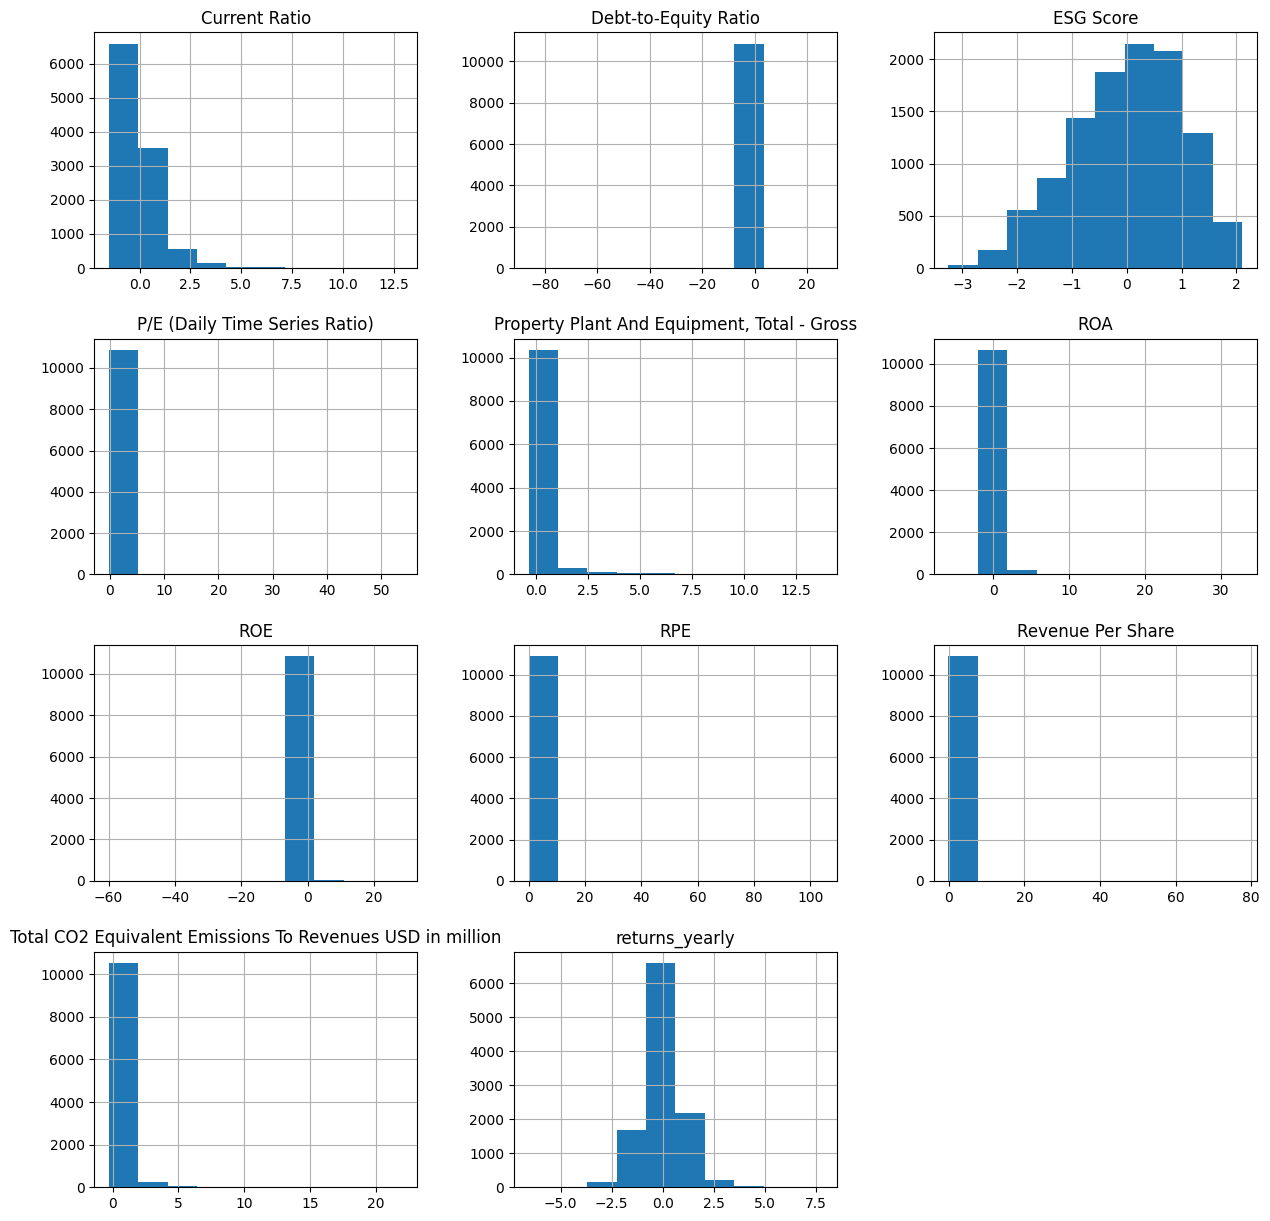

In [96]:
# export merged dataframe

imputed_data_wo.to_csv("data/imputed_data_with_outliers.csv")

# Plot a histogram

imputed_data_wo.hist(figsize=(15, 15))

### Model Training

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
columns_selected = [
    "Total Equity",
    "CO2 Emissions",
    "Company Market Capitalization",
    "PPE Total",
    "P/E (Daily Time Series Ratio)",
]

In [ ]:
X = df_firm_new[df_firm_new["Total Current Assets"] <= 5000][columns_selected]
y = df_firm_new[df_firm_new["Total Current Assets"] <= 5000]["ESG Score"]

In [ ]:
# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# model evaluation
print("mean_squared_error : ", mean_squared_error(y_test, y_pred))
print("mean_absolute_error : ", mean_absolute_error(y_test, y_pred))

In [ ]:
# create a KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=100)
scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=folds)
scores

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# model evaluation
print("mean_squared_error : ", mean_squared_error(y_test, y_pred))
print("mean_absolute_error : ", mean_absolute_error(y_test, y_pred))

In [ ]:
# create a KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=100)
scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=folds)
scores

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# model evaluation
print("mean_squared_error : ", mean_squared_error(y_test, y_pred))
print("mean_absolute_error : ", mean_absolute_error(y_test, y_pred))

In [ ]:
# create a KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=100)
scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=folds)
scores

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# model evaluation
print("mean_squared_error : ", mean_squared_error(y_test, y_pred))
print("mean_absolute_error : ", mean_absolute_error(y_test, y_pred))

In [ ]:
# create a KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=100)
scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=folds)
scores

In [ ]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(estimator=RandomForestRegressor())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# model evaluation
print("mean_squared_error : ", mean_squared_error(y_test, y_pred))
print("mean_absolute_error : ", mean_absolute_error(y_test, y_pred))

In [ ]:
# create a KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=100)
scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=folds)
scores